# Importing libraries

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# Importing and cleanup data

In [2]:
df = pd.read_csv('/kaggle/input/flcs-stock-market-transaction-2021-2022/flc_unlabeled_time_series.csv', delimiter=',');
df.info()
df['Volume MA'] = df['Volume MA'].fillna(df['Volume MA'].mean())
time = df['time'].str.split("T", expand = True)
df['time'] = time[0]
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       2170 non-null   object 
 1   open       2170 non-null   float64
 2   high       2170 non-null   float64
 3   low        2170 non-null   float64
 4   close      2170 non-null   float64
 5   Volume     2170 non-null   int64  
 6   Volume MA  2151 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 118.8+ KB


,time,open,high,low,close,Volume,Volume MA
0,2013-08-06,4104.330818,4176.336622,4032.325014,4104.330818,6158668,1.367749e+07
1,2013-08-07,4104.330818,4104.330818,3960.319210,4032.325014,4937960,1.367749e+07
2,2013-08-08,4032.325014,4104.330818,3960.319210,3960.319210,2287341,1.367749e+07
3,2013-08-09,3960.319210,4032.325014,3888.313406,3960.319210,2425496,1.367749e+07
4,2013-08-12,3960.319210,3960.319210,3816.307603,3816.307603,3534864,1.367749e+07
...,...,...,...,...,...,...,...
2165,2022-04-26,6810.000000,7280.000000,6700.000000,7280.000000,13263200,2.088446e+07
2166,2022-04-27,7280.000000,7780.000000,7010.000000,7780.000000,17725500,2.160832e+07
2167,2022-04-28,7900.000000,8320.000000,7830.000000,8250.000000,18449000,2.244248e+07
2168,2022-04-29,8290.000000,8820.000000,8290.000000,8820.000000,18600200,2.327746e+07


# Get time range

In [3]:
df['time'].min(), df['time'].max()

('2013-08-06', '2022-05-04')

# Extract necessary columns from datafram

In [4]:
df = df[['time', 'close']]
print(df['time'].min(), df['time'].max())
df.head()
df.info()

2013-08-06 2022-05-04
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    2170 non-null   object 
 1   close   2170 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.0+ KB


# Plotting data

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['close'], name='Close price'))
fig.update_layout(showlegend=True, title='FLC. Stock Price 2013-2022')
fig.show()

* It's obvious that after 2021, there's a spike in close price of FLC Stock
* We'll assume there're no anomaly before the 2021 point.

# Split training, testing data

In [6]:
train = df.loc[df['time'] <= '2021-01-01']
test = df.loc[df['time'] > '2021-01-01']
train.shape, test.shape

((1841, 2), (329, 2))

# Scaling data

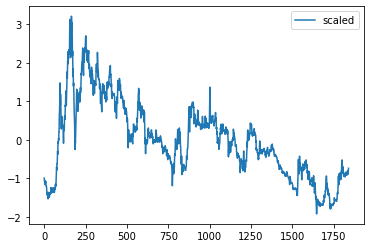

In [7]:
pd.options.mode.chained_assignment = None 

scaler = StandardScaler()
scaler = scaler.fit(np.array(train['close']).reshape(-1,1))

train['close'] = scaler.transform(np.array(train['close']).reshape(-1,1))
test['close'] = scaler.transform(np.array(test['close']).reshape(-1,1))

plt.plot(train['close'], label = 'scaled')
plt.legend()
plt.show()

# Create time sequences

In [8]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['close']], train['close'])
X_test, y_test = create_sequences(test[['close']], test['close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1811, 30, 1)
Testing input shape:  (299, 30, 1)


In [9]:
X_train[1810]

array([[-0.881444  ],
       [-0.944297  ],
       [-0.87001618],
       [-0.88715791],
       [-0.91572745],
       [-0.92144136],
       [-0.92144136],
       [-0.92715527],
       [-0.96143873],
       [-0.95001091],
       [-0.89858573],
       [-0.93286918],
       [-0.91001355],
       [-0.84144664],
       [-0.85858837],
       [-0.89287182],
       [-0.91001355],
       [-0.90429964],
       [-0.87001618],
       [-0.87001618],
       [-0.881444  ],
       [-0.91001355],
       [-0.89858573],
       [-0.80716319],
       [-0.80144928],
       [-0.89858573],
       [-0.881444  ],
       [-0.881444  ],
       [-0.85287446],
       [-0.77859364]])

# Set random seed

In [10]:
np.random.seed(21)
tf.random.set_seed(21)

# Building model

In [11]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

2022-09-07 08:01:22.936255: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

# Train model

In [12]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100


2022-09-07 08:01:23.757204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


51/51 [==============================] - 9s 80ms/step - loss: 0.2087 - val_loss: 0.0850
Epoch 2/100
51/51 [==============================] - 3s 62ms/step - loss: 0.1161 - val_loss: 0.0557
Epoch 3/100
51/51 [==============================] - 3s 66ms/step - loss: 0.1107 - val_loss: 0.0490
Epoch 4/100
51/51 [==============================] - 4s 76ms/step - loss: 0.0957 - val_loss: 0.0399
Epoch 5/100
51/51 [==============================] - 3s 63ms/step - loss: 0.0764 - val_loss: 0.0419
Epoch 6/100
51/51 [==============================] - 3s 64ms/step - loss: 0.0641 - val_loss: 0.0358
Epoch 7/100
51/51 [==============================] - 3s 62ms/step - loss: 0.0487 - val_loss: 0.0299
Epoch 8/100
51/51 [==============================] - 3s 60ms/step - loss: 0.0367 - val_loss: 0.0272
Epoch 9/100
51/51 [==============================] - 3s 62ms/step - loss: 0.0342 - val_loss: 0.0237
Epoch 10/100
51/51 [==============================] - 3s 59ms/step - loss: 0.0310 - val_loss: 0.0219
Epoch 11/10

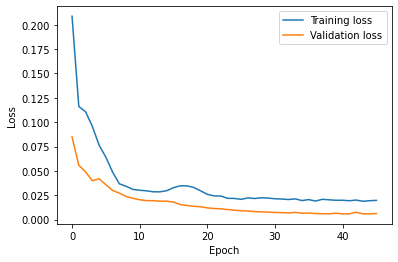

In [13]:
# Plotting training & validation loss

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Reconstruction error threshold: 2.101641872468326


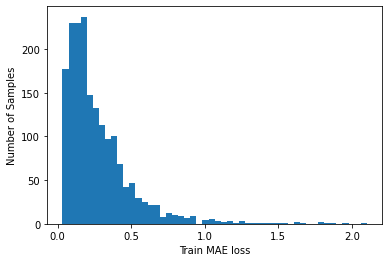

In [14]:
# Plotting MAE loss on train data

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# Predicting anomalies on test data

10/10 [==============================] - 0s 19ms/step


Text(0, 0.5, 'Number of samples')

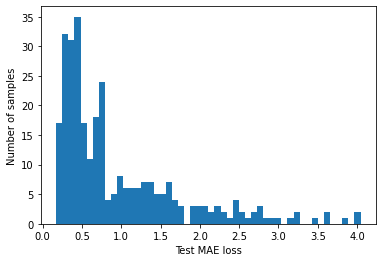

In [15]:
# Plotting MAE loss on test data

X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [16]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [17]:
anomaly_df.head()

,time,close,loss,threshold,anomaly
1871,2021-02-22,0.272766,0.407775,2.101642,False
1872,2021-02-23,0.175629,0.410371,2.101642,False
1873,2021-02-24,0.118490,0.356769,2.101642,False
1874,2021-02-25,0.147060,0.321240,2.101642,False
1875,2021-02-26,0.255624,0.288524,2.101642,False


In [18]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies

,time,close,loss,threshold,anomaly
1897,2021-03-30,3.861100,2.213681,2.101642,True
1898,2021-03-31,3.946809,2.486065,2.101642,True
1899,2021-04-01,3.546835,2.482120,2.101642,True
1900,2021-04-02,3.632544,2.109708,2.101642,True
2101,2022-01-18,4.632478,2.271564,2.101642,True
2102,2022-01-19,4.089657,2.759552,2.101642,True
2103,2022-01-20,3.575405,3.195414,2.101642,True
2104,2022-01-21,4.032518,3.591958,2.101642,True
2105,2022-01-24,3.518266,3.218829,2.101642,True
2106,2022-01-25,3.061153,3.500505,2.101642,True


In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['time'], y=anomaly_df['close'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['time'], y=anomalies['close'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()